In [1]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #Scale the data
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
import math

In [2]:
%store -r weather
df = weather
df

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),9am wind direction,9am wind speed (km/h),3pm Temperature (°C),3pm relative humidity (%),3pm wind direction,3pm wind speed (km/h),Avg Temp
0,2019-01-07,2.5,18.1,0.0,W,15.0,0:33,6.1,77.0,WNW,2,17.6,27.0,NNE,4,10.30
1,2019-02-07,3.2,22.4,0.0,NNW,31.0,14:16,7.7,68.0,NW,6,20.0,35.0,NNW,19,12.80
2,2019-03-07,6.3,17.4,0.0,S,24.0,13:52,12.4,53.0,SSW,4,14.6,84.0,S,15,11.85
3,2019-04-07,11.7,15.8,1.8,SE,30.0,13:21,13.7,81.0,SSW,15,14.4,88.0,SSE,15,13.75
4,2019-05-07,11.6,18.1,1.2,ESE,41.0,14:33,13.6,84.0,S,4,16.5,72.0,ESE,24,14.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2020-07-27,11.9,17.2,49.4,NW,50.0,1:43,14.2,84.0,NW,17,14.2,94.0,WNW,11,14.55
393,2020-07-28,10.0,14.1,17.4,NW,41.0,12:25,11.1,98.0,NW,20,13.1,92.0,NW,22,12.05
394,2020-07-29,9.0,19.4,4.0,S,20.0,12:19,12.2,99.0,WNW,4,18.7,53.0,W,4,14.20
395,2020-07-30,8.0,18.6,0.0,S,28.0,12:18,11.2,83.0,W,11,16.1,51.0,S,7,13.30


In [3]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df['Date']

0     2019-01-07
1     2019-02-07
2     2019-03-07
3     2019-04-07
4     2019-05-07
         ...    
392   2020-07-27
393   2020-07-28
394   2020-07-29
395   2020-07-30
396   2020-07-31
Name: Date, Length: 396, dtype: datetime64[ns]

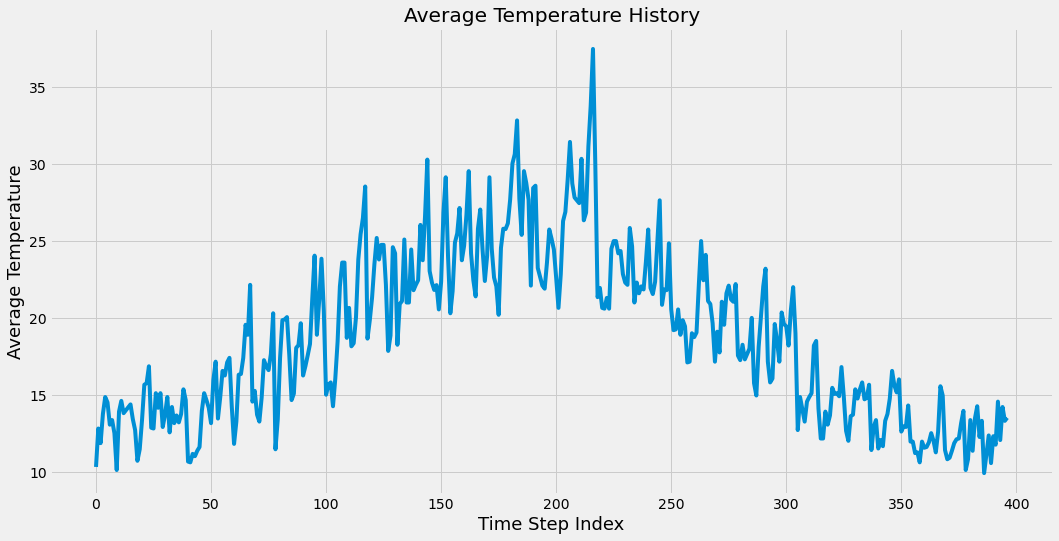

In [4]:
#Visualise the data
plt.figure(figsize = (16,8))
plt.title('Average Temperature History')
plt.plot(df['Avg Temp'])
plt.xlabel('Time Step Index', fontsize=18)
plt.ylabel('Average Temperature', fontsize = 18)
plt.show()

In [5]:
data = df[['Avg Temp', 'Rainfall (mm)']]
data.head()

,Avg Temp,Rainfall (mm)
0,10.30,0.0
1,12.80,0.0
2,11.85,0.0
3,13.75,1.8
4,14.85,1.2


In [6]:
training_data_len = math.ceil(len(data)*.8)
val_data_len = math.ceil(len(data)*.9)

training_data_len, val_data_len

(317, 357)

In [7]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        x.append(row)
        label=df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

In [8]:
x, y = df_to_x_y(data, window_size=20)
x.shape, y.shape

((376, 20, 2), (376,))

In [9]:
#Split the data into 80% training (testing 10% and svalidation 10%)
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size = 0.5, random_state=42)

In [10]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape 

((300, 20, 2), (38, 20, 2), (38, 20, 2), (300,), (38,), (38,))

In [11]:
#Standardize the data

#Make mean and std variables
temp_training_mean = np.mean(x_train[:, :, 0])
temp_training_std = np.std(x_train[:, :, 0])

#Make preprocessing function
def preprocess(x):
    x[:, :, 0] = (x[:, :, 0]-temp_training_mean)/temp_training_std
    return x

In [12]:
#Preprocvess all data
preprocess(x_train)
preprocess(x_val)
preprocess(x_test)

array([[[ 0.73945718,  2.6       ],
        [ 0.59922746,  4.6       ],
        [ 0.50885719,  0.        ],
        ...,
        [ 1.95478142,  0.        ],
        [ 0.95447608,  0.        ],
        [ 0.6272734 ,  0.        ]],

       [[-0.83111568,  0.        ],
        [-1.57900752,  0.        ],
        [-1.58835617,  0.        ],
        ...,
        [-0.53195895,  0.        ],
        [-0.37303193,  0.        ],
        [-0.31694005,  0.        ]],

       [[ 1.10405445,  0.2       ],
        [ 1.10405445,  0.2       ],
        [ 0.95447608,  0.        ],
        ...,
        [ 0.45899774,  0.        ],
        [ 0.60857611,  0.2       ],
        [ 1.1134031 ,  0.        ]],

       ...,

       [[-0.27954545,  0.2       ],
        [-0.83111568,  0.        ],
        [-0.75165218,  0.        ],
        ...,
        [-0.64414272,  0.        ],
        [-0.61609678,  0.        ],
        [-0.90590487,  0.        ]],

       [[ 1.3471193 ,  3.2       ],
        [ 1.45930307,  0.  

In [13]:
#Build LSTM model
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation = 'swish'))
model.add(Dense(1))

In [14]:
model.compile(optimizer = 'adam', loss = MeanSquaredError(), metrics = [RootMeanSquaredError()])

In [20]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 80, epochs = 10, shuffle = True)

Epoch 1/10
4/4 [==============================] - 0s 69ms/step - loss: 71.6360 - root_mean_squared_error: 8.4638 - val_loss: 47.7924 - val_root_mean_squared_error: 6.9132
Epoch 2/10
4/4 [==============================] - 0s 67ms/step - loss: 57.4868 - root_mean_squared_error: 7.5820 - val_loss: 37.8437 - val_root_mean_squared_error: 6.1517
Epoch 3/10
4/4 [==============================] - 0s 71ms/step - loss: 46.4047 - root_mean_squared_error: 6.8121 - val_loss: 31.0876 - val_root_mean_squared_error: 5.5756
Epoch 4/10
4/4 [==============================] - 0s 72ms/step - loss: 38.6150 - root_mean_squared_error: 6.2141 - val_loss: 27.0441 - val_root_mean_squared_error: 5.2004
Epoch 5/10
4/4 [==============================] - 0s 72ms/step - loss: 33.6874 - root_mean_squared_error: 5.8041 - val_loss: 25.1463 - val_root_mean_squared_error: 5.0146
Epoch 6/10
4/4 [==============================] - 0s 47ms/step - loss: 31.2803 - root_mean_squared_error: 5.5929 - val_loss: 24.7590 - val_root_m

In [16]:
#get the model's predicted values
predictions = model.predict(x_test)
predictions

2/2 [==============================] - 2s 8ms/step


array([[12.238967 ],
       [12.220801 ],
       [12.240369 ],
       [12.226271 ],
       [12.225813 ],
       [12.232383 ],
       [12.245443 ],
       [12.226507 ],
       [12.239995 ],
       [12.215517 ],
       [12.214358 ],
       [12.239403 ],
       [12.236026 ],
       [12.218006 ],
       [12.223324 ],
       [12.188084 ],
       [12.223334 ],
       [12.226705 ],
       [12.2241   ],
       [12.241668 ],
       [12.240468 ],
       [12.240557 ],
       [12.226363 ],
       [12.237417 ],
       [12.222603 ],
       [12.248021 ],
       [12.233689 ],
       [12.234159 ],
       [12.228766 ],
       [12.223161 ],
       [12.240453 ],
       [12.232493 ],
       [12.245117 ],
       [12.226779 ],
       [12.2336445],
       [12.22231  ],
       [12.149157 ],
       [12.222664 ]], dtype=float32)

C:\Users\tusha\AppData\Local\Temp\ipykernel_26108\103094583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_and_test['Predictions'] = predictions


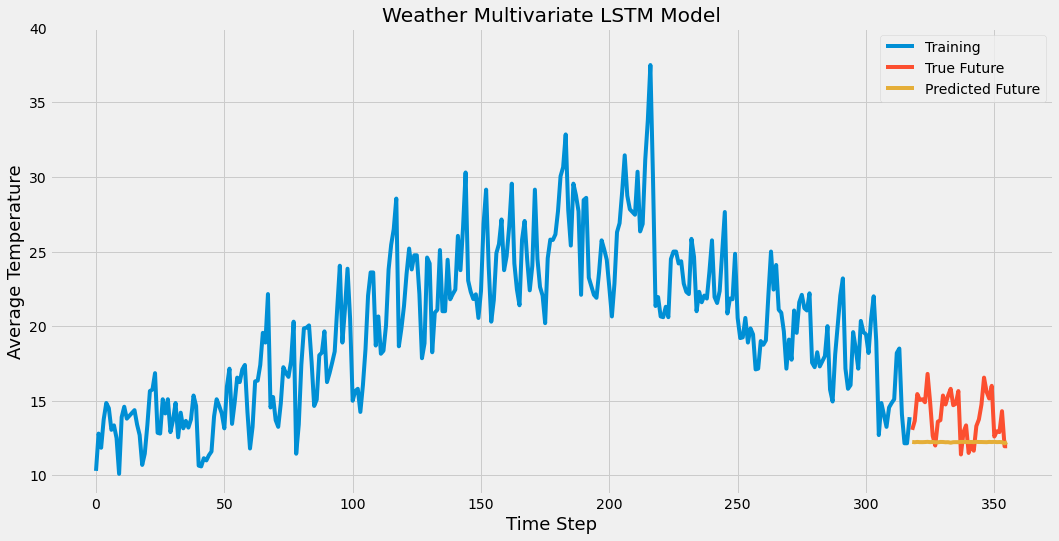

In [17]:
#Create dataframes
train = data[:training_data_len]
valid_and_test = data[training_data_len:val_data_len - 2]
valid_and_test['Predictions'] = predictions

#test = pd.DataFrame(data = {'Predictions': predictions})

#Visualise
plt.figure(figsize=(16,8))
plt.title('Weather Multivariate LSTM Model')
plt.xlabel("Time Step", fontsize = 18)
plt.ylabel('Average Temperature', fontsize = 18)
plt.plot(train['Avg Temp'])
plt.plot(valid_and_test[['Avg Temp', 'Predictions']])
plt.ylim(top = 40)
plt.legend(['Training', 'True Future', 'Predicted Future'])
plt.show()

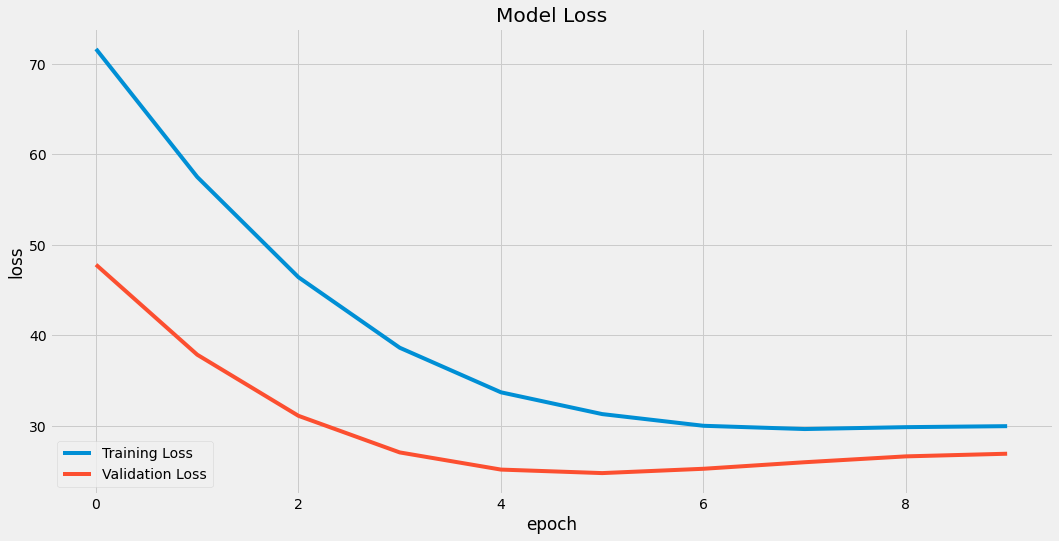

In [24]:
#Visualise loss
#Visualizing loss
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['Training Loss', 'Validation Loss'], loc='lower left')
plt.show()

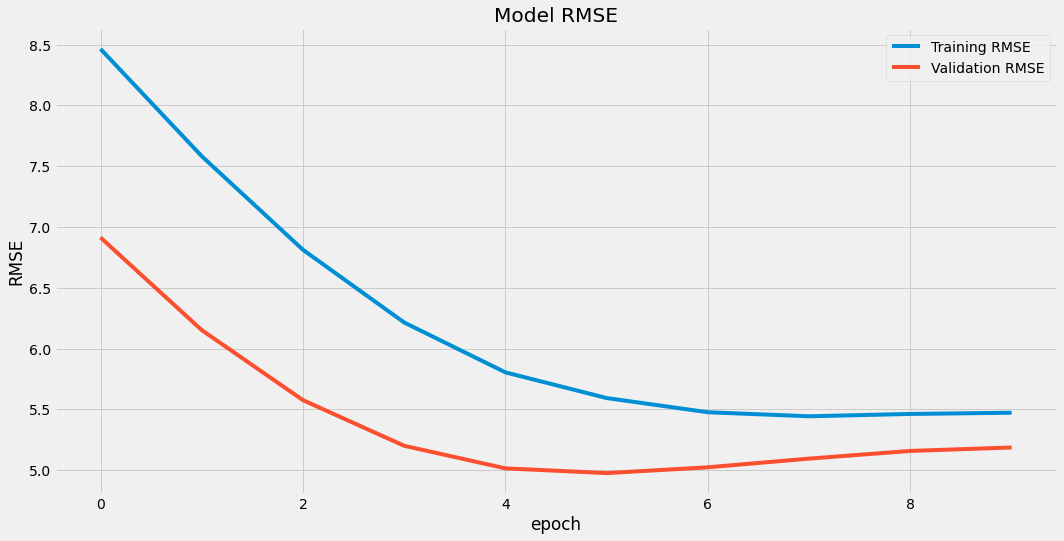

In [25]:
plt.figure(figsize = (16,8))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(['Training RMSE', 'Validation RMSE'], loc = 'upper right')
plt.show()